# Exercise 2

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random
from pprint import pprint
import numpy as np
import os
%matplotlib inline

In [2]:
try:
	os.mkdir('fig')
except:
	pass
try:
	os.mkdir('results')
except:
	pass

In [3]:
E = {
	'o':{
		'a':2/5,
		'b':1/5
	},
	'a':{
		'b':3/4,
		'c':1/4
	},
	'b':{
		'o':1/2,
		'c':1/2
	},
	'c':{
		'b':1/3,
		'd':2/3
	},
	'd':{
		'a':1/3,
		'c':1/3
	}
}

In [4]:
DG = nx.DiGraph()
edge_list = [(u,v,w) for u,e in E.items() for v,w in e.items()]
DG.add_weighted_edges_from(edge_list)

In [5]:
W = nx.adjacency_matrix(DG).toarray()
degrees = np.sum(W,axis=1)
D = np.diag(degrees)
P = np.linalg.inv(D) @ W
indices = dict()
for i in range(len(DG.nodes)):
    indices[list(DG.nodes)[i]] = i

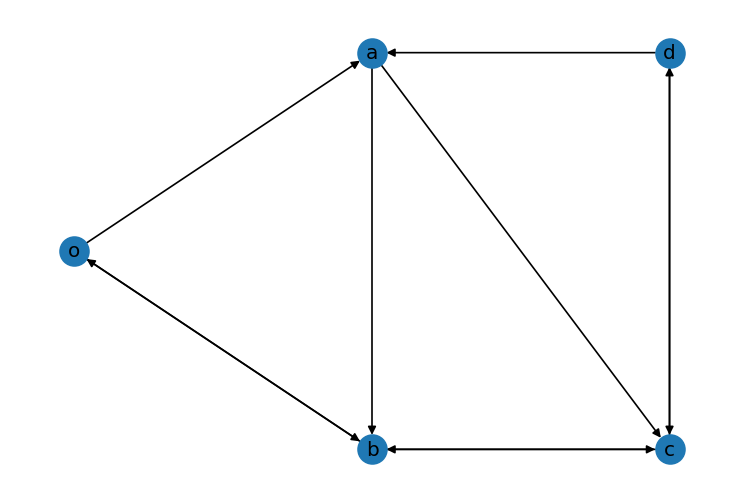

In [6]:
pos = {
    'o':[0,-1],
    'a':[2,0],
    'b':[2,-2],
    'd':[4,0],
	'c':[4,-2]
}
plt.figure(dpi=120)
nx.draw(DG, pos, with_labels=True)
plt.savefig('fig/graph1.png')

In [7]:
ws = degrees.max()
P_ = W / ws
P_ -= np.diag(P_)
P_ += np.diag(1 - degrees/ws*(1-np.diag(P)))

### Particle perspective

In [8]:
# function that simulates a move and returns destination
def move(P_, v):
	x = random.random()
	c = 0 # used to compute cumulative distribution
	for u,w in enumerate(list(P_[v])):
		c += w
		if x <= c: # lower bound found
			return u
	return u

In [9]:
def multi_return_time(P_, ws, indices, o, d, n_part, n_tests=int(1e4)):
	o = indices[o]
	d = indices[d]
	rts = []
	for _ in range(n_tests):
		tt = 0 # time passed during the test
		ttt = 0 # sum of times taken by every particle
		particles = [o]*n_part # position of the particles
		while len(particles) > 0:
			tt += random.expovariate(ws*len(particles)) # time to wait before moving from node
			part = random.randint(0, len(particles)-1)
			u = move(P_, particles[part])
			if u == d and particles[part] != d:
				ttt += tt
				particles.pop(part)
			else:
				particles[part] = u
		rts.append(ttt/n_part) # average time taken in this test
	rts = np.array(rts)
	return rts.mean()


In [10]:
rt100 = multi_return_time(P_, ws, indices, 'a', 'a', 100, int(1e3))
rt1 = multi_return_time(P_, ws, indices, 'a', 'a', 1, int(1e3))
rt100s = f'{rt100:.2f}'
print(f'{rt1:.2f}', rt100s)
with open('results/rt100.txt', 'w') as outf:
	outf.write(rt100s)

6.91 6.79


As the particles do not influence each other while moving, they take on average the average time taken by only one particle to return to the origin.

### Node perspective

In [11]:
def particle_distribution(P_, ws, indices, o, n_part, sim_time):
	o = indices[o]
	choices = range(len(P_)) # node indices
	d = [0]*len(P_) # number of particles per node
	d[o] = n_part
	res = [d.copy()] # number of particles per node for each time when a clock ticks
	t = [0] # list of times when a clock ticks
	tt = 0 # time past during simulation
	tt += random.expovariate(ws*n_part) # time to wait before moving from node
	while tt < sim_time:
		t.append(tt)
		u = random.choices(choices, d, k=1)[0] # choose node from which move a particle, using values in d as priorities
		d[u] -= 1
		d[move(P_, u)] += 1 
		res.append(d.copy())
		tt += random.expovariate(ws*n_part) # time to wait before moving from node
	return t, np.array(res)


In [12]:
# function used to print things
def aprint(v, k=None, ret=False):
	if k == None:
		s = '[%s]'%(', '.join(f'{x:.2f}' for x in v))
	else:
		s = '{%s}'%(', '.join(f"{kk}:{vv:.2f}" for kk,vv in zip(k,v)))
	print(s)
	if ret:
		return s

In [13]:
# function used to plot number of particles in nodes over time
def time_plot(t, v, labels, img, exclusions=[]):
	fig = plt.figure(dpi=200, figsize=(9,3))
	ax  = fig.add_subplot(111)
	ax.set_position([0.075,0.15,0.85,0.8])
	for l,i in zip(labels, range(v.shape[0])):
		if l not in exclusions:
			ax.plot(np.array(t), v[i,:].T, label=l, linewidth=0.8)
	ax.legend(loc = 'center left', bbox_to_anchor = (1.0, 0.5))
	ax.set_xlabel('time')
	ax.set_ylabel('number of particles')
	plt.savefig(f'fig/{img}.png')
	return fig

{o:21.09, a:14.76, b:22.73, c:19.93, d:21.49}


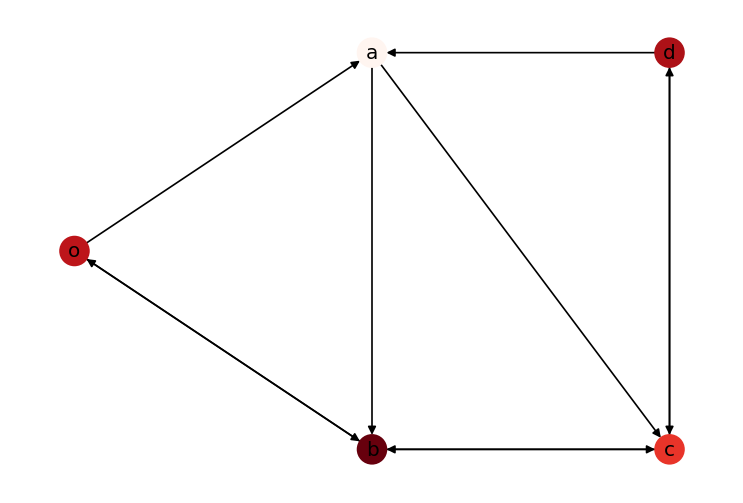

In [14]:
t, dd = particle_distribution(P_, ws, indices, 'o', 100, 60)
d = dd.mean(axis=0)
with open('results/avg_distribution.txt', 'w') as outf:
	outf.write(aprint(d, indices.keys(), ret=True))
plt.figure(dpi=120)
nx.draw(DG, pos, node_color=d, with_labels=True, cmap=plt.cm.Reds)
plt.savefig('fig/d.png')

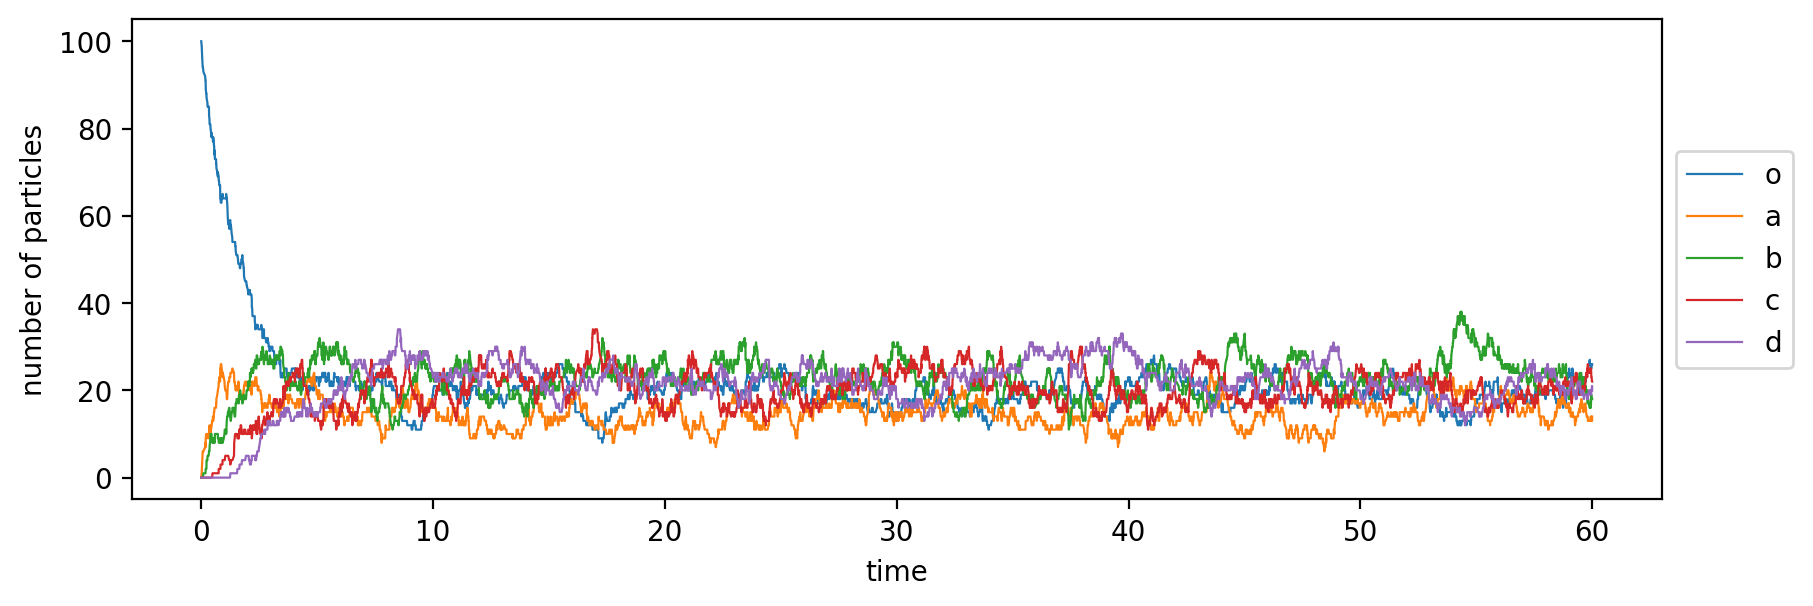

In [15]:
fig = time_plot(np.array(t), dd.T, indices.keys(), 't')

In [16]:
def dominant_eigenvector(P):
	l,v = np.linalg.eig(P)
	for i in range(len(l)):
		if np.isclose(l[i], 1):
			v = v[:,i].real
			v = v/np.linalg.norm(v,ord=1)
			if v.sum() < 0:
				return -v
			return v

{o:0.19, a:0.15, b:0.22, c:0.22, d:0.22}


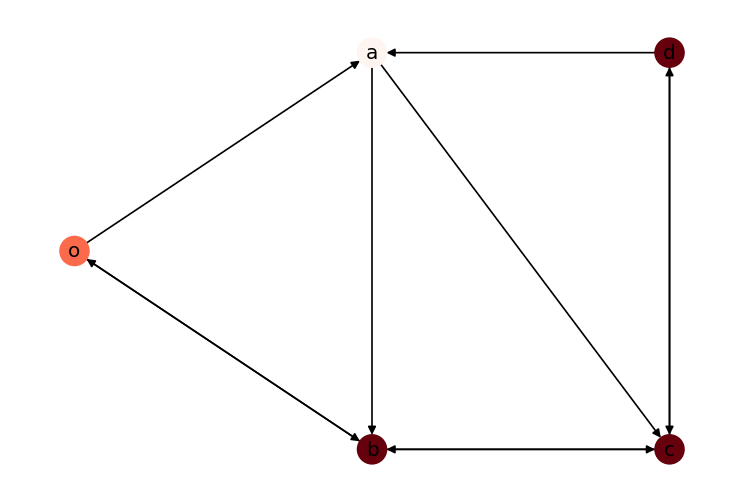

In [17]:
pi_ = dominant_eigenvector(P_.T)
aprint(pi_, indices.keys())
plt.figure(dpi=120)
nx.draw(DG, pos, node_color=pi_, with_labels=True, cmap=plt.cm.Reds)
plt.savefig('fig/pi.png')

We can se that the distribution of particles after 60 time units is similar to the stationary distribuion of the continuous time random walk followed by a single particle.

In [18]:
norm2 = f"{np.linalg.norm(d/100 - pi_):.3f}"
print(norm2)
with open('results/norm2.txt', 'w') as outf:
	outf.write(norm2)

0.036
